In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.stats_utils import load_statistics

from cdi.util.analysis.plotting import plot_comparison, plot_seaborn_comparison, barplot_comparison
from cdi.util.analysis.logs import collate_stats
from cdi.util.analysis.eval import (compute_avg_loglikelihood_w_std_err,
                                    compute_param_error)

## Analysis setup

### Global settings

In [6]:
data_name = 'fa_frey_processed'
# exp_seed_key = 'm20190508_d20200325_20200406_20200407'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm2019050811_d2020032511_20200406_20200407',
    'm2019050822_d2020032522_20200406_20200407',
    'm2019050833_d2020032533_20200406_20200407',
    'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [7]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs/{{}}'
log_path_base = f'../../trained_models/{data_name}/learning_experiments'

## Helpers

In [8]:
def read_experiment_stats(group, model, seed, filename):
    path = log_path_template.format(group, model, seed, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    return load_statistics(dirpath, filename)

def read_experiment_stats_all_seeds(group, model, filename):
    all_stats = defaultdict(list)
    for exp_seed in exp_seed_keys:
        path = log_path_template.format(group, model, exp_seed, filename)
        filename = os.path.basename(path)
        dirpath = os.path.dirname(path)
        stats = load_statistics(dirpath, filename)
        for k, v in stats.items():
            all_stats[k].append(v)
    
    return all_stats

def read_suite_stats_all_seeds(group, suite, filename):
    return {
        name: read_experiment_stats_all_seeds(group, model, filename)
        for name, model in suite.items()
    }

def read_suite_stats(group, suite, filename, seed):
    return {
        name: read_experiment_stats(group, model, seed, filename)
        for name, model in suite.items()
    }

def read_suite_stats_with_init_all_seeds(group, suite):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats_all_seeds(group, model, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, exp_seed_keys[0], 'init_summary.csv')):
            init_stats = read_experiment_stats_all_seeds(group, model, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

def read_suite_stats_with_init(group, suite, seed):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats(group, model, seed, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, seed, 'init_summary.csv')):
            init_stats = read_experiment_stats(group, model, seed, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

##

def read_all_suite_stats(groups, suite, filename, seed):
    return {
        group: read_suite_stats(group, suite, filename, seed)
        for group in groups
    }


## Learning curve analysis

### Likelihood analysis


#### Log-likelihood vs epoch

In [9]:
suite = {
    'Complete EM': 'fa_em_complete',
    'EM w/ miss': 'fa_em_joint',
    'Emp. imputation + MLE': 'fa_empirical_sample_baseline',
    'MICE + MLE': 'fa_mice_baseline',
    'VCDI': 'fa_pretrained_svar_cdi_const',
}

##### Single experiment

<IPython.core.display.Javascript object>


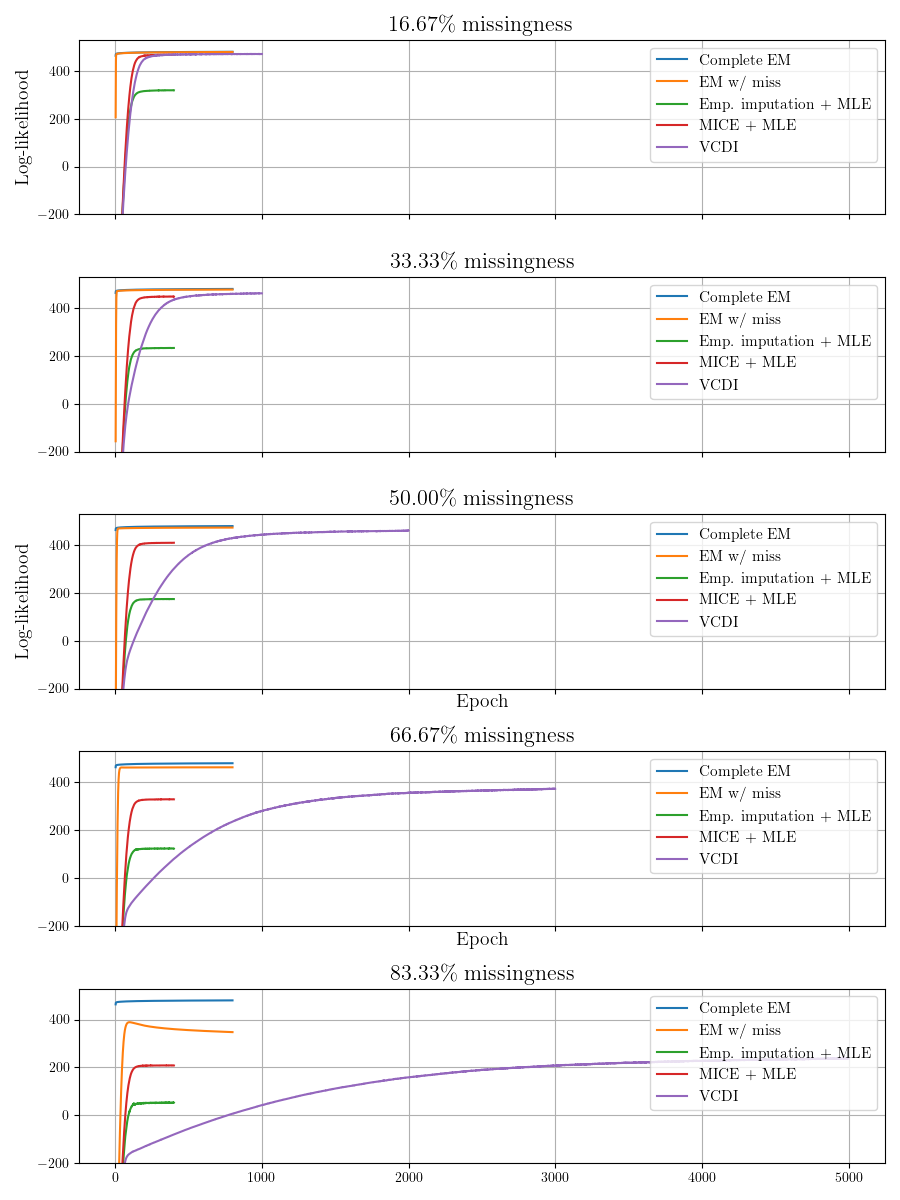

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True, figsize=(9, 12))
axes = axes.flatten()
# axes = [axes]
gs = [1, 2, 3, 4, 5]
# gs = [3]
for i, g in enumerate(gs):
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, 2):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    if i in (2, 3):
        xlabel='Epoch'
    else:
        xlabel=None
    
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('val_log_lik', ),
#                     y_metric_keys=('val_loss', ),#'aug_val_loss',),# 'train_loss', 'train_entropy'),
#                     y_metric_keys=('val_log_lik',),  
# #                     y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),
                    err_keys=(None,),
#                     err_keys=(None, None),
#                     err_keys=(None, None, None, None),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=(-200, 530))

# axes[0].set_xlim(left=-5, right=255)
# axes[1].set_xlim(left=-5, right=255)
# axes[2].set_xlim(left=-5, right=255)

fig.tight_layout()

##### Avg. over seeds

<IPython.core.display.Javascript object>


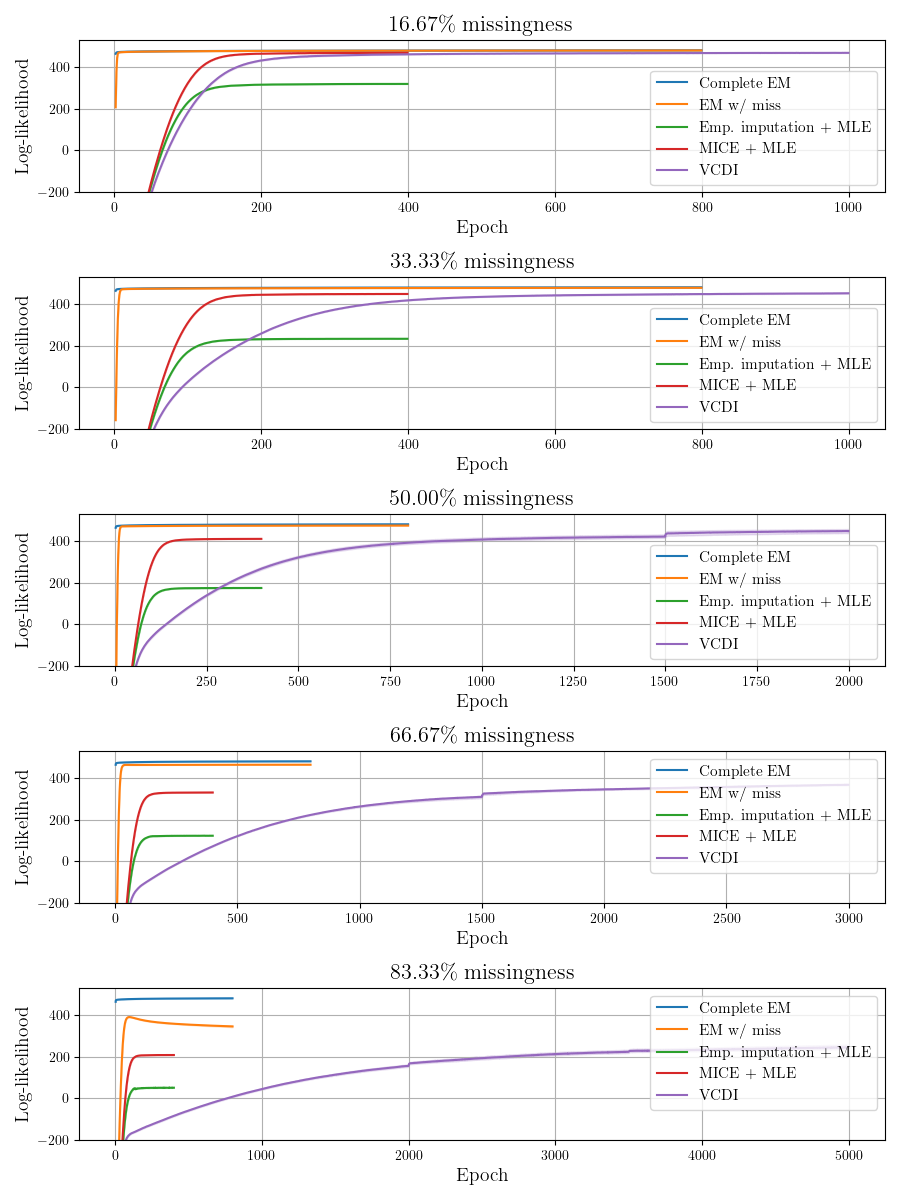

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 12))
# axes = [axes]
for i, g in enumerate([1, 2, 3, 4, 5]):
    stats = read_suite_stats_all_seeds(group=g, suite=suite, filename='summary.csv')

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel='Epoch'
    else:
        xlabel=None
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('val_log_lik',),
                    xlabel='Epoch',
                    ylabel='Log-likelihood', 
                    ylim=(-200, 530))

# axes[0].set_xlim(left=-5, right=255)
# axes[1].set_xlim(left=-5, right=255)
# axes[2].set_xlim(left=-5, right=255)

fig.tight_layout()

<IPython.core.display.Javascript object>


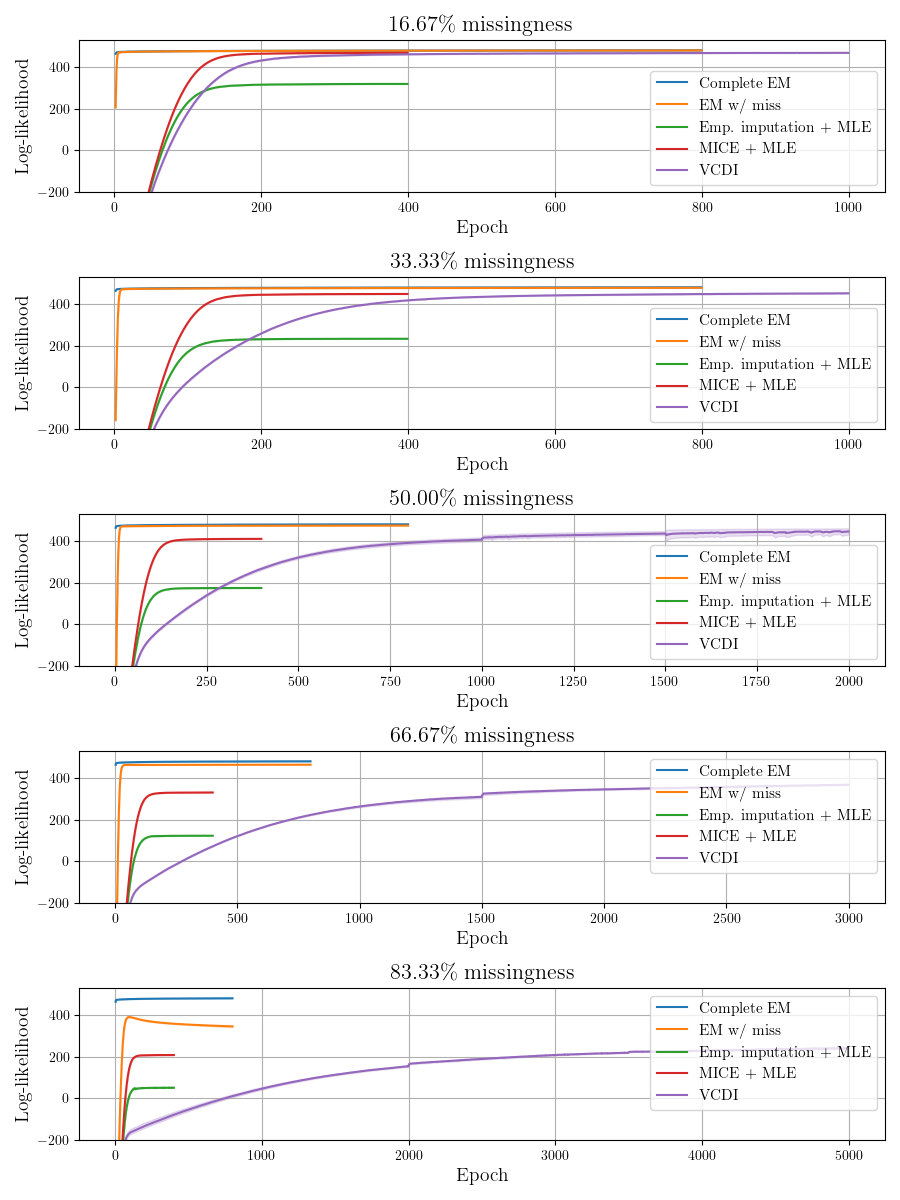

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 12))
# axes = [axes]
for i, g in enumerate([1, 2, 3, 4, 5]):
    stats = read_suite_stats_all_seeds(group=g, suite=suite, filename='summary.csv')

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel='Epoch'
    else:
        xlabel=None
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('val_log_lik',),
                    xlabel='Epoch',
                    ylabel='Log-likelihood', 
                    ylim=(-200, 530))

# axes[0].set_xlim(left=-5, right=255)
# axes[1].set_xlim(left=-5, right=255)
# axes[2].set_xlim(left=-5, right=255)

fig.tight_layout()

#### Log-likelihood vs # $p(x)$ evaluations

In [19]:
suite = {
#     'Complete MLE': 'fa_complete_data',
#     'Complete EM': 'fa_em_complete',
#     'EM w/ miss': 'fa_em_joint',
    'Emp. imputation + MLE': 'fa_empirical_sample_baseline',
    'MICE + MLE': 'fa_mice_baseline',
#     'MICE + MLE K=10': 'fa_mice_baseline_10_K10',
#     'MICE + MLE 50': 'fa_mice_baseline_50',
#     'VCDI sched1': 'fa_pretrained_svar_cdi_sched1',
#     'VCDI sched2 lr1e-3': 'fa_pretrained_svar_cdi_sched2_lr1e-3',
    'VCDI': 'fa_pretrained_svar_cdi',
#     'MCEM w/ missing $K=5$': 'fa_mcem_joint_5samples',
#     'MCEM w/ missing $K=5/10/20$': 'fa_mcem_joint',
}

##### Single experiment

<IPython.core.display.Javascript object>


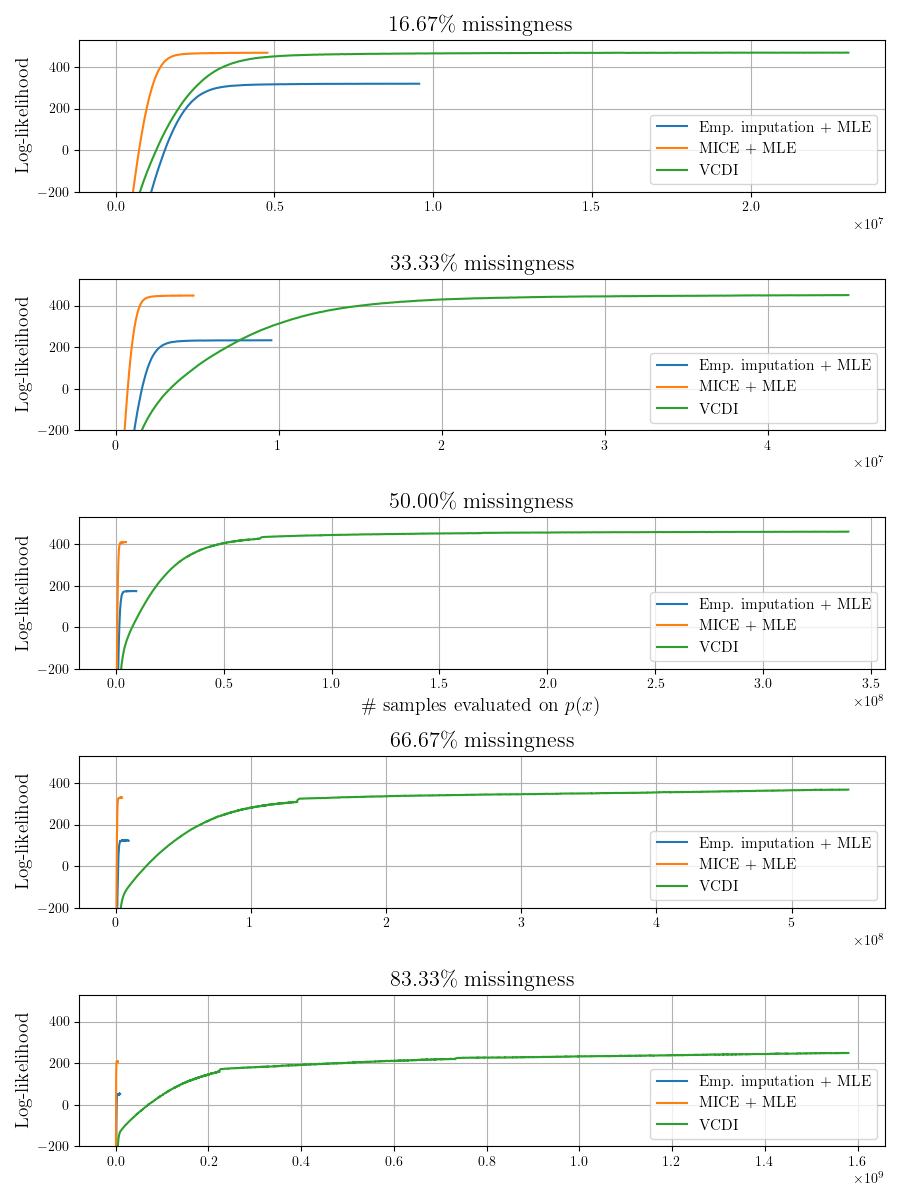

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 12))
# axes = [axes]
gs = [1, 2, 3, 4, 5]
for i, g in enumerate(gs):
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')
    for exp, metrics in stats.items():
        metrics['cum_fa_calls'] = np.cumsum(metrics['cum_fa_calls'])
#         metrics['cum_var_calls'] = np.cumsum(metrics['cum_var_calls'])

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel = '\# samples evaluated on $p(x)$'
    else:
        xlabel = None
    plot_comparison(axes[i], stats, 
                    x_metric_key='cum_fa_calls',
                    y_metric_keys=('val_log_lik',),  
# #                     y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),
                    err_keys=(None,),
#                     err_keys=(None, None),
#                     err_keys=(None, None, None),
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
#                     ylim=None)
                    ylim=(-200, 530))
#                     ylim=(-26, -17))
#                     ylim=(0, 10))

# axes[0].set_xlim(left=-10, right=5e6+10)
# axes[1].set_xlim(left=-10, right=5e6+10)
# axes[2].set_xlim(left=-10, right=5e6+10)

fig.tight_layout()

##### Avg. over seeds

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, sharex=True, figsize=(9, 12))
# axes = [axes]
gs = [1, 2, 3, 4, 5]
for i, g in enumerate(gs):
    stats = read_suite_stats_all_seeds(group=g, suite=suite, filename='summary.csv')
    for exp, metrics in stats.items():
        for j in range(len(metrics['cum_fa_calls'])):
            metrics['cum_fa_calls'][j] = np.cumsum(metrics['cum_fa_calls'][j])
        mean_cum_sum = np.mean(np.stack(metrics['cum_fa_calls']), axis=0)
        for j in range(len(metrics['cum_fa_calls'])):
            metrics['cum_fa_calls'][j] = mean_cum_sum

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel = '\# samples evaluated on $p(x)$'
    else:
        xlabel = None
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='cum_fa_calls',
                    y_metric_keys=('val_log_lik',),  
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-200, 530))

# axes[0].set_xlim(left=-10, right=5e6+10)
# axes[1].set_xlim(left=-10, right=5e6+10)
# axes[2].set_xlim(left=-10, right=5e6+10)

fig.tight_layout()

In [84]:
# fig.savefig('figures/toy_mcar_learning_curves_vs_num_px.pdf', bbox_inches='tight')

#### Log-likelihood vs time

In [23]:
suite = {
#     'Complete MLE': 'fa_complete_data',
    'Complete EM': 'fa_em_complete',
    'EM w/ miss': 'fa_em_joint',
    'Emp. imputation + MLE': 'fa_empirical_sample_baseline',
    'MICE + MLE': 'fa_mice_baseline',
#     'MICE + MLE K=10': 'fa_mice_baseline_10_K10',
#     'MICE + MLE 50': 'fa_mice_baseline_50',
#     'VCDI sched1': 'fa_pretrained_svar_cdi_sched1',
#     'VCDI sched2 lr1e-3': 'fa_pretrained_svar_cdi_sched2_lr1e-3',
    'VCDI': 'fa_pretrained_svar_cdi',
#     'MCEM w/ missing $K=5$': 'fa_mcem_joint_5samples',
#     'MCEM w/ missing $K=5/10/20$': 'fa_mcem_joint',
}

##### Single experiment

<IPython.core.display.Javascript object>


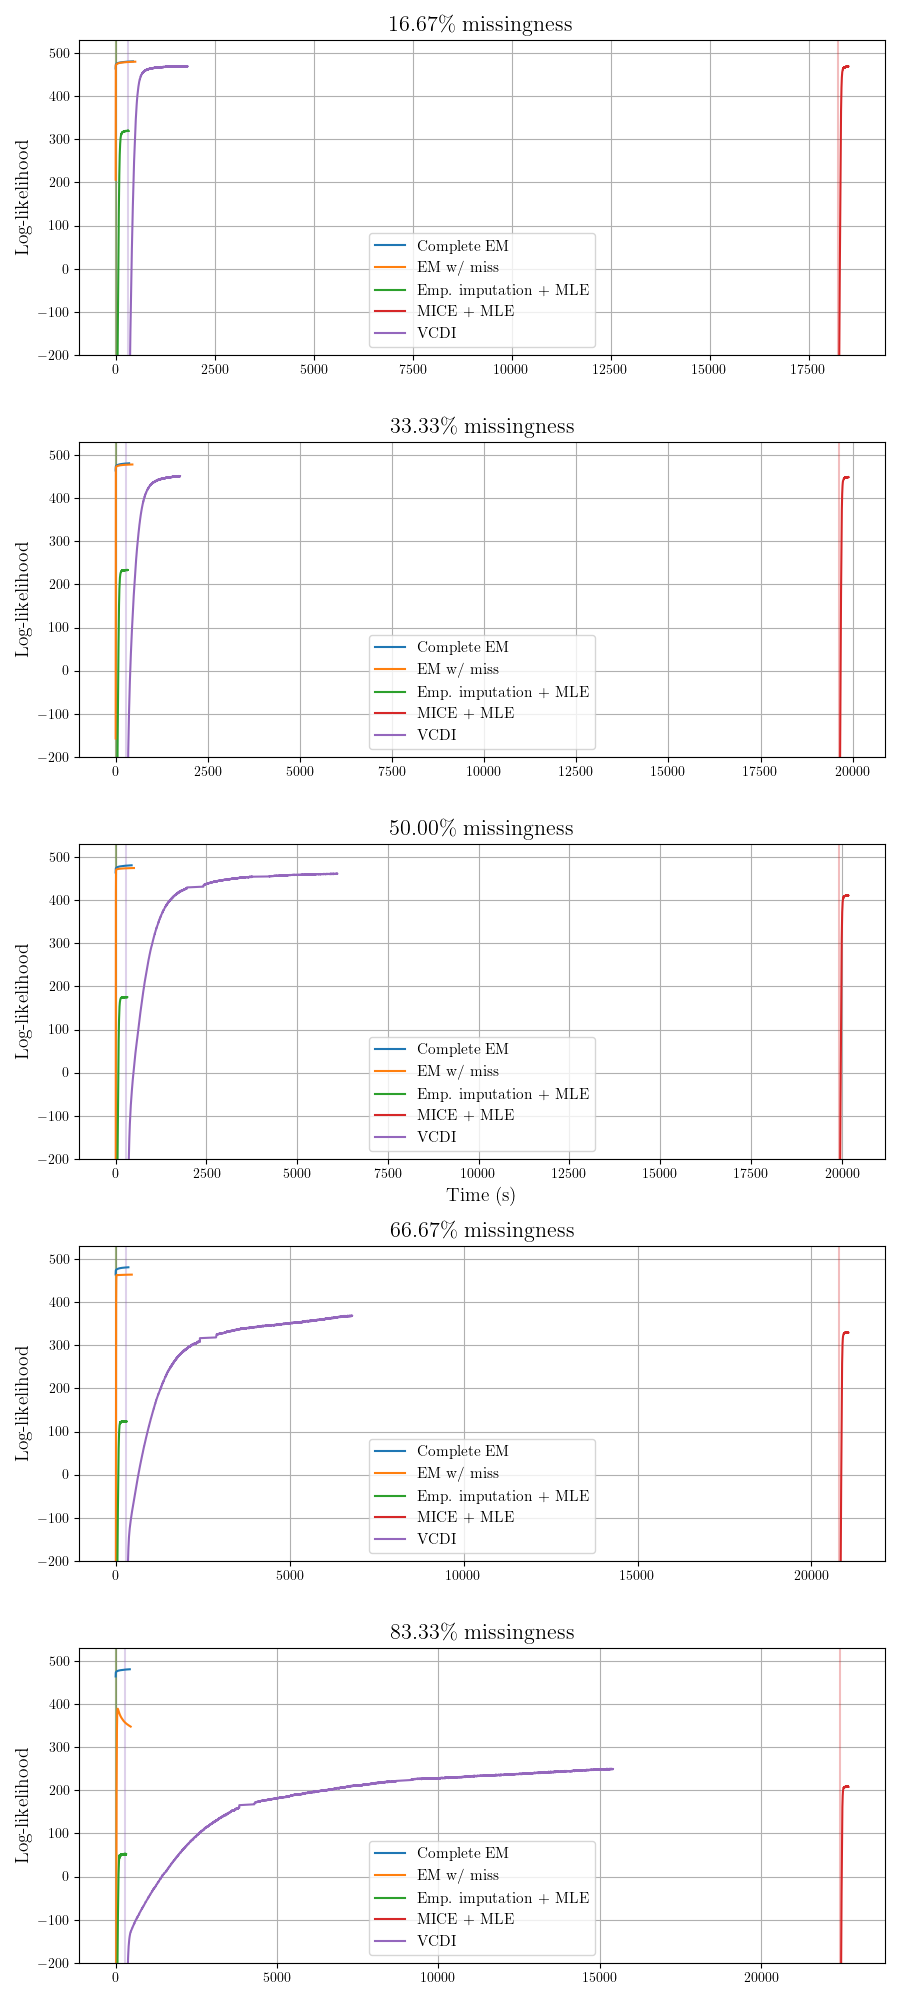

In [24]:
y_metrics = ('val_log_lik',)

fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 20))
# axes = [axes]
gs = [1, 2, 3, 4, 5]
for i, g in enumerate(gs):
    stats = read_suite_stats_with_init(group=g, suite=suite, seed=exp_seed_keys[0])
    v_lines = {}
    for exp, metrics in stats.items():
        metrics['train_time'] = np.cumsum(metrics['train_time'])
        if 'init_time' in metrics['init']:
            init_time = np.sum(metrics['init']['init_time'])
            metrics['train_time'] += init_time
            v_lines[exp] = init_time
        else:
            v_lines[exp] = None

    if i in (2,):
        xlabel = 'Time (s)'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
                    y_metric_keys=y_metrics,  
                    err_keys=(None, ),
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-200, 530))

# axes[0].set_xlim(left=-5, right=355)
# axes[1].set_xlim(left=-5, right=355)
# axes[2].set_xlim(left=-5, right=355)

fig.tight_layout()

##### Avg. over seeds

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 20))
# axes = [axes]
gs = [1,2,3,4,5]
for i, g in enumerate(gs):
    stats = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    v_lines = {}
    for exp, metrics in stats.items():
        for j in range(len(metrics['train_time'])):
            metrics['train_time'][j] = np.cumsum(metrics['train_time'][j])
        mean_time_cum_sum = np.mean(np.stack(metrics['train_time']), axis=0)
        for j in range(len(metrics['train_time'])):
            metrics['train_time'][j] = mean_time_cum_sum.copy()
            
        if 'init_time' in metrics['init']:
            for j in range(len(metrics['init']['init_time'])):
                metrics['init']['init_time'][j] = np.cumsum(metrics['init']['init_time'][j])
            mean_init_time_cum_sum = np.mean(np.stack(metrics['init']['init_time']), axis=0)
            init_time = np.sum(mean_init_time_cum_sum)
            for j in range(len(metrics['train_time'])):
                metrics['train_time'][j] += init_time

            v_lines[exp] = init_time
        else:
            v_lines[exp] = None

    if i in (2,):
        xlabel = 'Time (s)'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='train_time',
                    y_metric_keys=('val_log_lik',),  
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-200, 530))

# axes[0].set_xlim(left=-5, right=355)
# axes[1].set_xlim(left=-5, right=355)
# axes[2].set_xlim(left=-5, right=355)

fig.tight_layout()

### Var. model pretraining learning curve

In [18]:
suite = {
#     'Var': 'var_pretraining_1e-3',
    'Shared Var': 'svar_pretraining',
#     'Var test': 'var_pretraining_test',
}

<IPython.core.display.Javascript object>


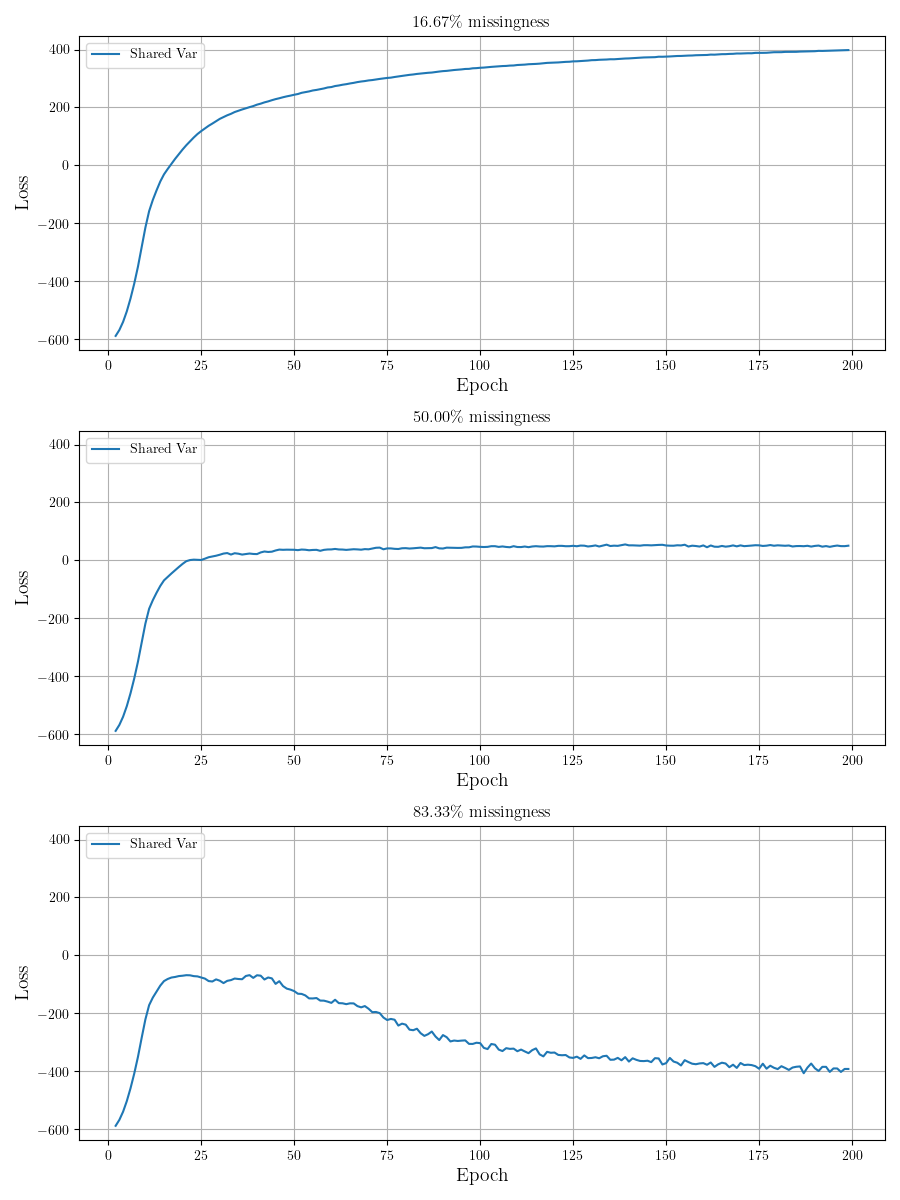

In [19]:
y_metrics = ('val_log_lik',#)
            'val_log_lik_0',
            'val_log_lik_1',
            'val_log_lik_2',
            'val_log_lik_3',
            'val_log_lik_4',
            'val_log_lik_5')
err_metrics = (None, None, None, None, None, None, None)
# metric_labels = ('log\_lik',#)
#                  'log\_lik dim(0)',
#                  'log\_lik dim(1)',
#                  'log\_lik dim(2)',
#                  'log\_lik dim(3)',
#                  'log\_lik dim(4)',
#                  'log\_lik dim(5)',)
metric_labels = None

fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 12))
# axes = [axes]
gs = [1, 3, 5]
for i, g in enumerate(gs):
    axes[i].set(title=f'{g/6*100:.2f}\% missingness')
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')
    
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=y_metrics,  
                    err_keys=err_metrics,
                    metric_labels=metric_labels,
                    xlabel='Epoch',
                    ylabel='Loss', 
                    ylim=None,
                    colors_instead_styles=False)

    axes[i].legend(loc='upper left')

fig.tight_layout()

### Time per epoch

#### Model test log-likelihood (relaxed vs not relaxed)

In [9]:
suite = {
    'shared extended': 'fa_pretrained_svar_cdi_const',
    'shared standard': 'fa_pretrained_svar_cdi_const_slow',
}

final_epochs = {
    'shared extended': ['last', 'last', 'last', 'last', 'last'],
    'shared standard': ['last', 'last', 'last', 'last', 'last'],
}

gs = [1, 2, 3, 4, 5]

In [10]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats[exp_name] = compute_param_error(model_name,
                                          seeds=exp_seed_keys,
                                          groups=gs,
                                          base_path=log_path_base)

<IPython.core.display.Javascript object>


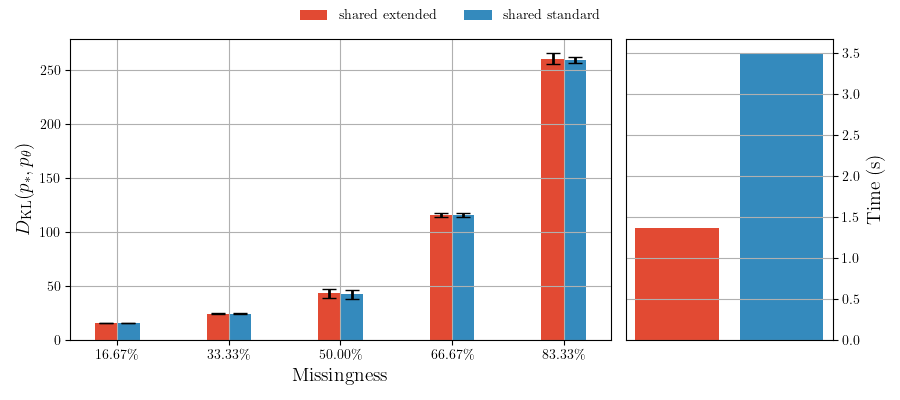

<ipython-input-11-15879e0f68d3>:60: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(rect=(0, 0, 1, 0.94))


In [11]:
fig = plt.figure(constrained_layout=True, figsize=(9, 4))
gridspec = fig.add_gridspec(1, 7)
axes = []
axes.append(fig.add_subplot(gridspec[:5]))
axes.append(fig.add_subplot(gridspec[5:]))

# ggplot
colors = ['#E24A33', '#348ABD',]
    
# plot_comparison(axes[0], stats, 
#                 x_metric_key='group',
#                 y_metric_keys=('KLD_avg',),  
#                 err_keys=('KLD_std_err',),
#                 xlabel='Missingness',
#                 ylabel='$D_{\\mathrm{KL}}(p_*, p_{\\mathbf{\\theta}})$', 
#                 colors=colors,
#                 ylim=None,
#                 x_jitter=[-0.05, 0.05])

barplot_comparison(axes[0], stats, width=0.2,
                    x_metric_key='group',
                    y_metric_keys=('KLD_avg',),  
                    err_keys=('KLD_std_err',),
                    xlabel='Missingness',
                    ylabel='$D_{\\mathrm{KL}}(p_*, p_{\\mathbf{\\theta}})$', 
                    colors=colors,
#                     ylim=(450, 1200),
#                       gap=0.02, gap_idx=1
                  )

axes[0].set_xticks(gs)
axes[0].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in gs))


stats_time = defaultdict(lambda: defaultdict(list))
for i, g in enumerate(gs):
    stats_g = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    for m, s in stats_g.items():
        if final_epochs[m][g-1] == 'last':
            time = np.mean(s['train_time'], axis=1)
        else:
            # If we early-stopping, count time until stopped
            time = np.mean(np.array(s['train_time'])[:, :final_epochs[m][g-1]], axis=1)

        stats_time[m]['train_time'].append(time.mean())

for i, (m, s) in enumerate(stats_time.items()):
    avg_time = np.mean(stats_time[m]['train_time'])
    
    axes[1].bar(m, avg_time, color=colors[i])

axes[1].set_xticks([])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
axes[1].set_ylabel('Time (s)', fontsize=14)
# plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
axes[1].grid()
    
fig.tight_layout(rect=(0, 0, 1, 0.94))

axes[0].legend(ncol=4, bbox_to_anchor=(0.5, 0.96), bbox_transform=fig.transFigure, loc='center', 
                  frameon=False)

In [12]:
# fig.savefig('figures/fa_frey_time_and_kldiv_relaxed_vs_not_relaxed.pdf', bbox_inches='tight')